In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

audio_files_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/"
folders = os.listdir(audio_files_path)
print(folders)
real_audio = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

print("Real Audio:")
#IPython.display.Audio(real_audio)
print("Fake Audio:")
#IPython.display.Audio(fake_audio)

real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)
        

feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

feature_df["class"].value_counts()

def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

feature_df["class"] = label_encoder(feature_df["class"])

X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

y_resampled = to_categorical(y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

num_labels = len(feature_df["class"].unique())
num_labels

input_shape = feature_df["features"][0].shape
input_shape

model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

early = EarlyStopping(monitor="val_loss", patience=5)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=100, callbacks=[early])

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])
    
test_real = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
test_fake = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

detect_fake(test_real)
detect_fake(test_fake)


label ['fake' 'real']


100%|██████████| 55438/55438 [11:41<00:00, 79.02it/s] 
c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,970 (265.51 KB)

 Trainable params: 67,970 (265.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5219 - loss: 5.0540 - val_accuracy: 0.6681 - val_loss: 0.6726
Epoch 2/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5715 - loss: 0.6865 - val_accuracy: 0.6931 - val_loss: 0.6049
Epoch 3/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6732 - loss: 0.6109 - val_accuracy: 0.8249 - val_loss: 0.4082
Epoch 4/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7861 - loss: 0.4637 - val_accuracy: 0.8651 - val_loss: 0.3193
Epoch 5/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8322 - loss: 0.3847 - val_accuracy: 0.8709 - val_loss: 0.2991
Epoch 6/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8501 - loss: 0.3483 - val_accuracy: 0.8845 - val_loss: 0.2680
Epoch 7/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8654 - loss: 0.3204 - val_accuracy: 0.8932 - val_loss: 0.2587
Epoch 8/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8719 - loss: 0.3048 - val_accuracy: 0.

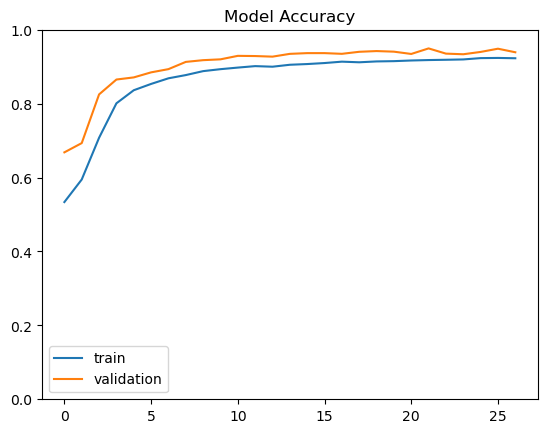

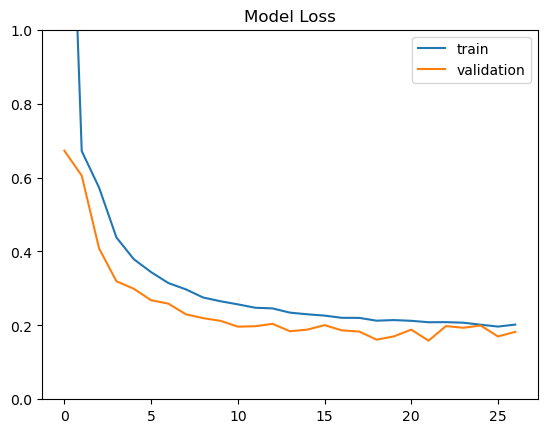

100%|██████████| 50000/50000 [14:44<00:00, 56.55it/s]

   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:38 63ms/step

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
combined_score_fake: 0.03612016138909796
combined_score_real: 0.03612016148263572
Combined Score on Validation Data: 0.03612


InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/activation_4_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\moon0\anaconda3\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\moon0\anaconda3\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\moon0\anaconda3\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\moon0\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\moon0\AppData\Local\Temp\ipykernel_13044\3868404946.py", line 247, in <module>

  File "C:\Users\moon0\AppData\Local\Temp\ipykernel_13044\3868404946.py", line 237, in detect_fake

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 508, in predict

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 208, in one_step_on_data_distributed

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 198, in one_step_on_data

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 96, in predict_step

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 556, in call

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\layers\activations\activation.py", line 31, in call

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\activations\activations.py", line 47, in relu

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\activations\activations.py", line 99, in static_call

  File "c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [1,40], In[1]: [13,128]
	 [[{{node sequential_1_1/activation_4_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_162350]

In [2]:
# 필요한 라이브러리를 임포트합니다.
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, mean_squared_error

# 파일 경로 설정
hackaton_folder = './'  # 현재 폴더
train_csv_path = os.path.join(hackaton_folder, 'train.csv')
test_csv_path = os.path.join(hackaton_folder, 'test.csv')
sample_submission_path = os.path.join(hackaton_folder, 'sample_submission.csv')
train_audio_folder = os.path.join(hackaton_folder, '')
test_audio_folder = os.path.join(hackaton_folder, '')
unlabeled_audio_folder = os.path.join(hackaton_folder, '')

# train.csv 파일을 로드합니다.
df = pd.read_csv(train_csv_path)

# Label 인코딩
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

df['class'] = label_encoder(df['label'])

# MFCC 특징 추출 함수
def get_mfcc_feature(df, folder, train_mode=True):
    features = []
    labels = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        file_path = os.path.join(folder, row['path'])
        if os.path.isfile(file_path):
            y, sr = librosa.load(file_path, sr=32000)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc = np.mean(mfcc.T, axis=0)
            features.append(mfcc)
            if train_mode:
                label = row['class']
                labels.append(label)
        else:
            print(f"File not found: {file_path}")
    if train_mode:
        return features, labels
    return features

# Train 데이터에서 MFCC 특징 추출
train_mfcc, train_labels = get_mfcc_feature(df, train_audio_folder, True)

# 데이터가 비어 있는지 확인
if not train_mfcc or not train_labels:
    raise ValueError("No features or labels extracted from the training data. Check the file paths and data extraction process.")

# Train 데이터를 DataFrame으로 변환
train_feature_df = pd.DataFrame({'features': train_mfcc, 'class': train_labels})

# X와 y 데이터 준비
X = np.array(train_feature_df['features'].tolist())
y = np.array(train_feature_df['class'].tolist())

# 데이터 불균형 해결
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
y_resampled = to_categorical(y_resampled)

# Train/Validation 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 모델 구성
model = Sequential()
model.add(Dense(128, input_shape=(13,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))  # fake와 real 두 개의 클래스를 예측
model.add(Activation('softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 요약
model.summary()

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=50, callbacks=[early_stopping])

# Validation 데이터 평가
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# 학습 곡선 시각화
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# 평가 함수 정의
def expected_calibration_error(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece

def auc_brier_ece(answer_df, submission_df):
    # Check for missing values in submission_df
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")

    # Check if the number and names of columns are the same in both dataframes
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")

    # Calculate AUC for each class
    auc_scores = []
    for column in answer_df.columns:
        y_true = answer_df[column]
        y_scores = submission_df[column]
        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)

    # Calculate mean AUC
    mean_auc = np.mean(auc_scores)

    brier_scores = []
    ece_scores = []

    # Calculate Brier Score and ECE for each class
    for column in answer_df.columns:
        y_true = answer_df[column].values
        y_prob = submission_df[column].values

        # Brier Score
        brier = mean_squared_error(y_true, y_prob)
        brier_scores.append(brier)

        # ECE
        ece = expected_calibration_error(y_true, y_prob)
        ece_scores.append(ece)

    # Calculate mean Brier Score and mean ECE
    mean_brier = np.mean(brier_scores)
    mean_ece = np.mean(ece_scores)

    # Calculate combined score
    combined_score = 0.5 * (1 - mean_auc) + 0.25 * mean_brier + 0.25 * mean_ece

    return combined_score

# 테스트 데이터 예측
test_df = pd.read_csv(test_csv_path)
test_mfcc = get_mfcc_feature(test_df, test_audio_folder, False)
test_mfcc = np.array(test_mfcc)

# 모델 예측
predictions = model.predict(test_mfcc)

# 제출 파일 생성
submit = pd.read_csv(sample_submission_path)
submit['fake'] = predictions[:, 0]
submit['real'] = predictions[:, 1]
submit.to_csv('./sg_submit.csv', index=False)
submit.head()

# 최종 모델의 성능 평가
# Validation 데이터로 성능 평가
val_preds = model.predict(X_val)

# 각 클래스 별로 실제 값과 예측 값을 따로 평가합니다.
val_true_fake = y_val[:, 0]
val_true_real = y_val[:, 1]
val_preds_fake = val_preds[:, 0]
val_preds_real = val_preds[:, 1]

# 각 클래스 별로 AUC, Brier Score, ECE 계산
fake_auc = roc_auc_score(val_true_fake, val_preds_fake)
real_auc = roc_auc_score(val_true_real, val_preds_real)

fake_brier = mean_squared_error(val_true_fake, val_preds_fake)
real_brier = mean_squared_error(val_true_real, val_preds_real)

fake_ece = expected_calibration_error(val_true_fake, val_preds_fake)
real_ece = expected_calibration_error(val_true_real, val_preds_real)

# Combined score 계산
combined_score_fake = 0.5 * (1 - fake_auc) + 0.25 * fake_brier + 0.25 * fake_ece
combined_score_real = 0.5 * (1 - real_auc) + 0.25 * real_brier + 0.25 * real_ece

# 최종 Combined score
print("combined_score_fake:", combined_score_fake)
print("combined_score_real:", combined_score_real)

combined_score_val = (combined_score_fake + combined_score_real) / 2
print(f'Combined Score on Validation Data: {combined_score_val:.5f}')

def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

# 테스트 예측
test_real = os.path.join(hackaton_folder, 'unlabeled_data/ABJGMLHQ.ogg')
test_fake = os.path.join(hackaton_folder, 'unlabeled_data/ZIKAHDQO.ogg')

detect_fake(test_real)
detect_fake(test_fake)


In [4]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.calibration import calibration_curve

# CSV 파일에서 오디오 파일 경로 및 레이블 읽기
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

data = []
labels = []

# 훈련 데이터 처리
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_path = row['path']  # CSV 파일의 경로 열 이름에 맞게 조정
    label = row['label']  # CSV 파일의 레이블 열 이름에 맞게 조정

    audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
    data.append(mfccs_features_scaled)
    labels.append(label)

# Unlabeled 데이터 처리
unlabeled_data_dir = 'unlabeled_data'
for root, dirs, files in os.walk(unlabeled_data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append('unknown')  # 레이블 없는 데이터

# Feature DataFrame 생성
feature_df = pd.DataFrame({"features": data, "class": labels})

# 레이블 인코딩
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

feature_df["class"] = label_encoder(feature_df["class"])

X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

# 데이터 균형 맞추기
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

y_resampled = to_categorical(y_resampled)

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

num_labels = len(feature_df["class"].unique())

input_shape = (X.shape[1],)

# 모델 생성 (TensorFlow를 사용하는 예시이므로 PyTorch로 변환해야 할 수 있음)
model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

early = EarlyStopping(monitor="val_loss", patience=5)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=2, epochs=100, callbacks=[early])

# 평가 함수 정의

def expected_calibration_error(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece

def auc_brier_ece(answer_df, submission_df):
    # Check for missing values in submission_df
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")

    # Check if the number and names of columns are the same in both dataframes
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")
        
    submission_df = submission_df[submission_df.iloc[:, 0].isin(answer_df.iloc[:, 0])]
    submission_df.index = range(submission_df.shape[0])
    
    # Calculate AUC for each class
    auc_scores = []
    for column in answer_df.columns[1:]:
        y_true = answer_df[column]
        y_scores = submission_df[column]
        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)

    # Calculate mean AUC
    mean_auc = np.mean(auc_scores)

    brier_scores = []
    ece_scores = []
    
    # Calculate Brier Score and ECE for each class
    for column in answer_df.columns[1:]:
        y_true = answer_df[column].values
        y_prob = submission_df[column].values
        
        # Brier Score
        brier = mean_squared_error(y_true, y_prob)
        brier_scores.append(brier)
        
        # ECE
        ece = expected_calibration_error(y_true, y_prob)
        ece_scores.append(ece)
    
    # Calculate mean Brier Score and mean ECE
    mean_brier = np.mean(brier_scores)
    mean_ece = np.mean(ece_scores)
    
    # Calculate combined score
    combined_score = 0.5 * (1 - mean_auc) + 0.25 * mean_brier + 0.25 * mean_ece
    
    return combined_score

# 테스트 데이터 예측 및 제출 파일 생성
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    
    # Debug prints
    print("Result Array Shape:", result_array.shape)
    print("Result Array Values:", result_array)
    
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    
    print("Argmax Result:", result)
    
    return result_classes[result]

# 예측 함수를 사용하여 각 파일에 대한 예측 결과 리스트 생성
predictions = []
for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = row['path']  # CSV 파일의 경로 열 이름에 맞게 조정
    prediction = detect_fake(file_path)
    predictions.append(prediction)

# 예측 결과를 DataFrame으로 만들어 CSV 파일로 저장
submit = pd.read_csv('./sample_submission.csv')
submit.iloc[:, 1:] = predictions
submit.to_csv('./sg_submit.csv', index=False)

# baseline_submit.csv 파일이 생성되었음을 알림
print("sg_submit3.csv 파일이 생성되었습니다.")

# 모델 평가
def evaluate_model(model, X, y_true):
    y_prob = model.predict(X)
    y_pred = np.argmax(y_prob, axis=1)
    
    # Convert y_true from categorical back to integer labels
    y_true = np.argmax(y_true, axis=1)
    
    # Calculate AUC
    auc = roc_auc_score(y_true, y_prob[:, 1])  # Assuming 1 is the index for the positive class
    
    # Calculate Brier Score
    brier = mean_squared_error(y_true, y_prob[:, 1])
    
    # Calculate ECE
    ece = expected_calibration_error(y_true, y_prob[:, 1])
    
    # Calculate combined score
    combined_score = 0.5 * (1 - auc) + 0.25 * brier + 0.25 * ece
    
    print("AUC:", auc)
    print("Brier Score:", brier)
    print("ECE:", ece)
    print("Combined Score (AUC, Brier Score, ECE):", combined_score)

# X_val, y_val는 검증 데이터셋입니다.
evaluate_model(model, X_val, y_val)


100%|██████████| 55438/55438 [33:50<00:00, 27.30it/s]


class ['fake' 'real' 'unknown']


c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,555 (279.51 KB)

 Trainable params: 71,555 (279.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
33382/33382 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.7876 - loss: 1.3297 - val_accuracy: 0.9532 - val_loss: 0.1616
Epoch 2/100
33382/33382 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9184 - loss: 0.2840 - val_accuracy: 0.9667 - val_loss: 0.1281
Epoch 3/100
33382/33382 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9312 - loss: 0.2686 - val_accuracy: 0.9673 - val_loss: 0.1223
Epoch 4/100
33382/33382 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.9316 - loss: 0.2666 - val_accuracy: 0.9642 - val_loss: 0.1358
Epoch 5/100
33382/33382 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.9367 - loss: 0.2635 - val_accuracy: 0.9674 - val_loss: 0.1300
Epoch 6/100
33382/33382 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9342 - loss: 0.2750 - val_accuracy: 0.9710 - val_loss: 0.1171
Epoch 7/100
33382/33382 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.9364 - loss: 0.2724 - val_accuracy: 0.9720 - val_loss: 0.1293
Epoch 8/100
33382/33382 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - ac

  0%|          | 0/50000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  0%|          | 0/50000 [00:00<?, ?it/s]

Result Array Shape: (1, 3)
Result Array Values: [[0. 0. 1.]]
Argmax Result: 2


IndexError: list index out of range